In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# STEP 2: Install PyTorch with GPU Support (CUDA 11.8)
#!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118 --quiet

import torch

# Check GPU Availability
print("PyTorch Version:", torch.__version__)
print("CUDA Available:", torch.cuda.is_available())

# Display GPU Name if available
if torch.cuda.is_available():
    print("GPU Detected:", torch.cuda.get_device_name(0))
else:
    print("⚠️ No GPU detected. Go to: Runtime > Change runtime type > Select GPU")

In [ ]:
import os
import numpy as np
import cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random


IMG_SIZE = 256
IMG_EXTS = (".tif", ".tiff", ".png", ".jpg", ".jpeg")


LGG_ROOT = ""# change with your path of complete dataset please
if not os.path.exists(LGG_ROOT):
    raise FileNotFoundError(f"Dataset not found at {LGG_ROOT}")

print(f"Dataset Root: {LGG_ROOT}")


def find_pairs_in_patient_folder(patient_folder):
    files = sorted(os.listdir(patient_folder))
    file_set = set(files)
    pairs = []

    for f in files:
        if "_mask" in f.lower():
            base, ext = os.path.splitext(f)
            if ext.lower() not in IMG_EXTS:
                continue

            img_base = base.rsplit("_mask", 1)[0]

            for e in IMG_EXTS:
                candidate = img_base + e
                if candidate in file_set:
                    pairs.append(
                        (os.path.join(patient_folder, candidate),
                         os.path.join(patient_folder, f))
                    )
                    break
    return pairs

image_paths, mask_paths = [], []

for patient in sorted(os.listdir(LGG_ROOT)):
    p = os.path.join(LGG_ROOT, patient)
    if os.path.isdir(p):
        pairs = find_pairs_in_patient_folder(p)
        for img_p, mask_p in pairs:
            image_paths.append(img_p)
            mask_paths.append(mask_p)

if len(image_paths) == 0:
    raise RuntimeError("No image-mask pairs found!")

print(f"Total pairs found: {len(image_paths)}")


def preprocess_mri(img, mask, size=256):
    """
    img  : grayscale MRI
    mask : binary mask
    """


    img = cv2.resize(img, (size, size), interpolation=cv2.INTER_LINEAR)
    mask = cv2.resize(mask, (size, size), interpolation=cv2.INTER_NEAREST)

    # Convert to float
    img = img.astype(np.float32)


    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    img = clahe.apply(img.astype(np.uint8))

    img = img.astype(np.float32)


    non_zero = img[img > 0]

    if len(non_zero) > 0:
        mean = non_zero.mean()
        std = non_zero.std() + 1e-8
        img = (img - mean) / std
    else:
        img = img / 255.0  # fallback

    # -----------------
    # Mask binarization
    # -----------------
    mask = (mask > 0).astype(np.float32)

    # -----------------
    # Expand dims
    # -----------------
    img = np.expand_dims(img, axis=-1)
    mask = np.expand_dims(mask, axis=-1)

    return img, mask

# -------------------------
# Load & preprocess
# -------------------------
images, masks = [], []

print("Loading and preprocessing images...")
for img_p, mask_p in tqdm(zip(image_paths, mask_paths), total=len(image_paths)):
    img = cv2.imread(img_p, cv2.IMREAD_GRAYSCALE)
    mask = cv2.imread(mask_p, cv2.IMREAD_GRAYSCALE)

    if img is None or mask is None:
        continue

    img, mask = preprocess_mri(img, mask, IMG_SIZE)

    # OPTIONAL: skip empty masks (helps Dice stability)
    if mask.sum() == 0:
        continue

    images.append(img)
    masks.append(mask)

images = np.array(images, dtype=np.float32)
masks = np.array(masks, dtype=np.float32)

print("Final dataset:")
print("Images:", images.shape)
print("Masks :", masks.shape)

# -------------------------
# Train / Val / Test split
# -------------------------
X_train, X_temp, y_train, y_temp = train_test_split(
    images, masks, test_size=0.30, random_state=42, shuffle=True
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, shuffle=True
)

print("\nDataset split:")
print("Train:", X_train.shape)
print("Val  :", X_val.shape)
print("Test :", X_test.shape)

# -------------------------
# Sanity visualization
# -------------------------
idxs = random.sample(range(len(X_train)), min(4, len(X_train)))
fig, axs = plt.subplots(4, 2, figsize=(8, 12))

for i, idx in enumerate(idxs):
    axs[i,0].imshow(X_train[idx].squeeze(), cmap='gray')
    axs[i,0].set_title("Preprocessed MRI")
    axs[i,1].imshow(y_train[idx].squeeze(), cmap='gray')
    axs[i,1].set_title("Mask")
    axs[i,0].axis('off')
    axs[i,1].axis('off')

plt.tight_layout()
plt.show()

In [1]:
import numpy as np

BASE_PATH = "processed_splits"

X_train = np.load(f"{BASE_PATH}/X_train.npy")
y_train = np.load(f"{BASE_PATH}/y_train.npy")

X_val   = np.load(f"{BASE_PATH}/X_val.npy")
y_val   = np.load(f"{BASE_PATH}/y_val.npy")

X_test  = np.load(f"{BASE_PATH}/X_test.npy")
y_test  = np.load(f"{BASE_PATH}/y_test.npy")

print("Train:", X_train.shape, y_train.shape)
print("Val  :", X_val.shape, y_val.shape)
print("Test :", X_test.shape, y_test.shape)

Train: (2750, 256, 256, 1) (2750, 256, 256, 1)
Val  : (589, 256, 256, 1) (589, 256, 256, 1)
Test : (590, 256, 256, 1) (590, 256, 256, 1)




### Step 4: Building the ResUpNet Model (Residual U-Net + ResNet50 Encoder + Attention Skip Fusion)



In [2]:

import tensorflow as tf
from tensorflow.keras import layers, models, backend as K
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import numpy as np
import matplotlib.pyplot as plt
import scipy.spatial.distance as sdist
import cv2
import os
import math



def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    return 1 - (2. * intersection + smooth) / (
        tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth
    )

def combo_loss(y_true, y_pred):
    return dice_loss(y_true, y_pred) + tf.keras.losses.binary_crossentropy(y_true, y_pred)

def focal_loss(gamma=2., alpha=0.25):
    def loss_fn(y_true, y_pred):
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        eps = K.epsilon()
        y_pred_f = K.clip(y_pred_f, eps, 1. - eps)
        pt = tf.where(tf.equal(y_true_f, 1), y_pred_f, 1 - y_pred_f)
        w = alpha * K.pow(1. - pt, gamma)
        fl = - w * K.log(pt)
        return K.mean(fl)
    return loss_fn

def hybrid_loss(alpha=0.5, gamma=2.0):
    fl = focal_loss(gamma=gamma, alpha=0.25)
    def loss(y_true, y_pred):
        return alpha * dice_loss(y_true, y_pred) + (1.0 - alpha) * fl(y_true, y_pred)
    return loss

def iou_metric(y_true, y_pred, thresh=0.5, smooth=1e-6):
    y_pred = tf.cast(y_pred > thresh, tf.float32)
    inter = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - inter
    return (inter + smooth) / (union + smooth)



def iou_keras(y_true, y_pred): return iou_metric(y_true, y_pred)
def precision_keras(y_true, y_pred):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    tp = tf.reduce_sum(y_true * y_pred)
    predicted_positive = tf.reduce_sum(y_pred)
    return tp / (predicted_positive + K.epsilon())

def recall_keras(y_true, y_pred):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    tp = tf.reduce_sum(y_true * y_pred)
    actual_positive = tf.reduce_sum(y_true)
    return tp / (actual_positive + K.epsilon())

def f1_keras(y_true, y_pred):
    p = precision_keras(y_true, y_pred)
    r = recall_keras(y_true, y_pred)
    return 2 * p * r / (p + r + K.epsilon())

In [3]:
def attention_gate(x, g, inter_channels):

    # Simple attention gate as in Attention U-Net.
    # x: skip connection feature map
    # g: gating signal (decoder)

    theta_x = layers.Conv2D(inter_channels, 1, strides=1, padding='same')(x)
    phi_g = layers.Conv2D(inter_channels, 1, strides=1, padding='same')(g)
    add = layers.Add()([theta_x, phi_g])
    relu = layers.Activation('relu')(add)
    psi = layers.Conv2D(1, 1, strides=1, padding='same')(relu)
    sig = layers.Activation('sigmoid')(psi)


    out = layers.Multiply()([x, sig])
    return out



def residual_conv_block(x, filters, kernel_size=3):
    shortcut = x
    x = layers.Conv2D(filters, kernel_size, padding='same', kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(filters, kernel_size, padding='same', kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    # Project shortcut if needed
    if shortcut.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, 1, padding='same')(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)
    x = layers.Add()([x, shortcut])
    x = layers.Activation('relu')(x)
    return x


def build_resupnet(input_shape=(256,256,1), pretrained=True, train_encoder=True):

    # ResUpNet:
    #  - input_shape: grayscale (H,W,1)
    #  - pretrained: use ImageNet weights for ResNet50 encoder
    #  - train_encoder: whether encoder layers are trainable

    # Input and convert to 3-channel required by ResNet50
    inp = layers.Input(shape=input_shape, name='input_image')
    # repeat channels to make 3 channels
    x = layers.Concatenate()([inp, inp, inp])  # shape -> (H,W,3)

    # Pretrained ResNet50 encoder
    base = ResNet50(include_top=False, weights='imagenet' if pretrained else None, input_tensor=x)
    base.trainable = train_encoder

    skips = [
        base.get_layer('conv1_relu').output,         # 128x128
        base.get_layer('conv2_block3_out').output,   # 64x64
        base.get_layer('conv3_block4_out').output,   # 32x32
        base.get_layer('conv4_block6_out').output    # 16x16
    ]
    bottleneck = base.get_layer('conv5_block3_out').output  # 8x8

    # Decoder: progressive upsampling, attention on skip, residual conv blocks
    d = bottleneck
    filters = [512, 256, 128, 64]  # matching decoder filters

    for i, f in enumerate(filters):
        # upsample
        d = layers.UpSampling2D(size=(2,2), interpolation='bilinear')(d)
        # attention gate on skip connection
        skip = skips[-(i+1)]
        att = attention_gate(skip, d, inter_channels=f//4)
        # concatenate
        d = layers.Concatenate()([d, att])
        # residual conv block
        d = residual_conv_block(d, f)

    # Final upsample to original resolution (from 128 -> 256 if needed)
    d = layers.UpSampling2D(size=(2,2), interpolation='bilinear')(d)
    d = residual_conv_block(d, 32)

    # Output
    out = layers.Conv2D(1, (1,1), padding='same', activation='sigmoid', name='mask')(d)

    model = models.Model(inputs=inp, outputs=out, name='ResUpNet')
    return model

In [4]:
def channel_attention(x, ratio=8):
    ch = x.shape[-1]
    avg = layers.GlobalAveragePooling2D()(x)
    avg = layers.Dense(ch // ratio, activation='relu')(avg)
    avg = layers.Dense(ch, activation='sigmoid')(avg)
    avg = layers.Reshape((1,1,ch))(avg)
    return layers.Multiply()([x, avg])


def spatial_attention(x):
    avg = tf.reduce_mean(x, axis=-1, keepdims=True)
    mx  = tf.reduce_max(x, axis=-1, keepdims=True)
    concat = layers.Concatenate()([avg, mx])
    att = layers.Conv2D(1, 7, padding='same', activation='sigmoid')(concat)
    return layers.Multiply()([x, att])


def dual_attention(x):
    x = channel_attention(x)
    x = spatial_attention(x)
    return x


def residual_block(x, filters):
    shortcut = x
    x = layers.Conv2D(filters, 3, padding='same', kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters, 3, padding='same', kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)

    if shortcut.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, 1, padding='same')(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    x = layers.Add()([x, shortcut])
    return layers.Activation('relu')(x)


def aspp_lite(x, filters):
    conv1 = layers.Conv2D(filters, 1, padding='same', activation='relu')(x)
    conv3 = layers.Conv2D(filters, 3, dilation_rate=2, padding='same', activation='relu')(x)
    conv5 = layers.Conv2D(filters, 3, dilation_rate=4, padding='same', activation='relu')(x)
    x = layers.Concatenate()([conv1, conv3, conv5])
    x = layers.Conv2D(filters, 1, padding='same', activation='relu')(x)
    return x


def attention_gate_hybrid(x, g, filters):
    theta = layers.Conv2D(filters, 1, padding='same')(x)
    phi   = layers.Conv2D(filters, 1, padding='same')(g)
    add   = layers.Add()([theta, phi])
    act   = layers.Activation('relu')(add)
    psi   = layers.Conv2D(1, 1, padding='same', activation='sigmoid')(act)
    return layers.Multiply()([x, psi])


def build_hybrid_resupnet(input_shape=(256,256,1)):
    inp = layers.Input(shape=input_shape)

    # ---------- Stem (MRI-friendly)
    x = layers.Conv2D(32, 3, padding='same', activation='relu')(inp)
    x = layers.BatchNormalization()(x)

    # ---------- Encoder (light residual)
    e1 = residual_block(x, 32)
    p1 = layers.MaxPooling2D()(e1)

    e2 = residual_block(p1, 64)
    p2 = layers.MaxPooling2D()(e2)

    e3 = residual_block(p2, 128)
    p3 = layers.MaxPooling2D()(e3)

    e4 = residual_block(p3, 256)
    p4 = layers.MaxPooling2D()(e4)

    # ---------- Bottleneck (multi-scale)
    b = aspp_lite(p4, 256)
    b = dual_attention(b)

    # ---------- Decoder
    d4 = layers.UpSampling2D()(b)
    s4 = attention_gate_hybrid(e4, d4, 64)
    d4 = layers.Concatenate()([d4, s4])
    d4 = residual_block(d4, 256)

    d3 = layers.UpSampling2D()(d4)
    s3 = attention_gate_hybrid(e3, d3, 32)
    d3 = layers.Concatenate()([d3, s3])
    d3 = residual_block(d3, 128)

    d2 = layers.UpSampling2D()(d3)
    s2 = attention_gate_hybrid(e2, d2, 16)
    d2 = layers.Concatenate()([d2, s2])
    d2 = residual_block(d2, 64)

    d1 = layers.UpSampling2D()(d2)
    s1 = attention_gate_hybrid(e1, d1, 8)
    d1 = layers.Concatenate()([d1, s1])
    d1 = residual_block(d1, 32)


    out = layers.Conv2D(1, 1, activation='sigmoid')(d1)

    return models.Model(inp, out, name="Hybrid_ResUpNet_Lite")

In [5]:
model = build_resupnet()

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=combo_loss,
    metrics=[
        'accuracy',
        dice_coef,
        iou_keras,
        precision_keras,
        recall_keras,
        f1_keras
    ]
)

model.summary()

Model: "ResUpNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_image         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 256, 256,  │          0 │ input_image[0][0… │
│ (Concatenate)       │ 3)                │            │ input_image[0][0… │
│                     │                   │            │ input_image[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 262, 262,  │          0 │ concatenate[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 128, 128,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 128, 128,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 130, 130,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 64, 64,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 64, 64,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 64, 64,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 64, 64,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 64, 64,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 46,373,013 (176.90 MB)

 Trainable params: 46,313,941 (176.67 MB)

 Non-trainable params: 59,072 (230.75 KB)

In [ ]:
#2nd trial

In [6]:
import numpy as np
import scipy.spatial.distance as sdist
from skimage import measure



def dice_np(y_true, y_pred, smooth=1e-6):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    inter = np.sum(y_true_f * y_pred_f)
    return (2. * inter + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

def iou_np(y_true, y_pred, smooth=1e-6):
    inter = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred) - inter
    return (inter + smooth) / (union + smooth)

def precision_np(y_true, y_pred, smooth=1e-6):
    tp = np.sum(y_true * y_pred)
    fp = np.sum((1 - y_true) * y_pred)
    return tp / (tp + fp + smooth)

def recall_np(y_true, y_pred, smooth=1e-6):
    tp = np.sum(y_true * y_pred)
    fn = np.sum(y_true * (1 - y_pred))
    return tp / (tp + fn + smooth)

def f1_np(y_true, y_pred):
    p = precision_np(y_true, y_pred)
    r = recall_np(y_true, y_pred)
    return 2 * p * r / (p + r + 1e-6)

def specificity_np(y_true, y_pred, smooth=1e-6):
    tn = np.sum((1 - y_true) * (1 - y_pred))
    fp = np.sum((1 - y_true) * y_pred)
    return tn / (tn + fp + smooth)

def hd95_np(y_true, y_pred):
    y_true_pts = np.argwhere(y_true > 0)
    y_pred_pts = np.argwhere(y_pred > 0)

    if len(y_true_pts) == 0 or len(y_pred_pts) == 0:
        return 0.0  # safe fallback

    d1 = sdist.cdist(y_true_pts, y_pred_pts)
    d2 = sdist.cdist(y_pred_pts, y_true_pts)
    return max(np.percentile(d1.min(axis=1), 95),
               np.percentile(d2.min(axis=1), 95))
def asd_np(y_true, y_pred):
    """
    Average Surface Distance (ASD)
    Computes mean bidirectional surface distance
    """

    # Ensure binary
    y_true = y_true.squeeze()
    y_pred = y_pred.squeeze()

    # Extract contours (surface pixels)
    true_contours = measure.find_contours(y_true, 0.5)
    pred_contours = measure.find_contours(y_pred, 0.5)

    if len(true_contours) == 0 or len(pred_contours) == 0:
        return 0.0  # safe fallback (no tumor)

    # Stack contour points
    true_pts = np.vstack(true_contours)
    pred_pts = np.vstack(pred_contours)

    # Pairwise distances
    d_true_to_pred = sdist.cdist(true_pts, pred_pts)
    d_pred_to_true = sdist.cdist(pred_pts, true_pts)

    # Mean of minimum distances
    asd = (np.mean(d_true_to_pred.min(axis=1)) +
           np.mean(d_pred_to_true.min(axis=1))) / 2.0

    return asd

In [7]:

import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.spatial.distance as sdist

class EpochEvaluationCallback(tf.keras.callbacks.Callback):
    def __init__(self, X_val, y_val, threshold=0.5, max_samples=None):
        super().__init__()
        self.X_val = X_val
        self.y_val = y_val
        self.threshold = threshold
        self.max_samples = max_samples


    def on_epoch_end(self, epoch, logs=None):
        all_dice, all_iou, all_prec, all_rec, all_f1 = [], [], [], [], []
        all_hd95, all_asd = [], []

        idxs = range(len(self.X_val))
        if self.max_samples:
            idxs = idxs[:self.max_samples]

        for i in idxs:
            x = self.X_val[i:i+1]
            y_true = self.y_val[i].squeeze()

            y_prob = self.model.predict(x, verbose=0)[0, ..., 0]
            y_pred = (y_prob > self.threshold).astype(np.float32)

            d = dice_np(y_true, y_pred)
            j = iou_np(y_true, y_pred)
            p = precision_np(y_true, y_pred)
            r = recall_np(y_true, y_pred)
            f1 = f1_np(p, r)

            h = hd95_np(y_true, y_pred)
            a = asd_np(y_true, y_pred)

            all_dice.append(d)
            all_iou.append(j)
            all_prec.append(p)
            all_rec.append(r)
            all_f1.append(f1)
            all_hd95.append(h)
            all_asd.append(a)

        print(f"\n📊 Epoch {epoch+1} — Validation Metrics:")
        print(f"Dice:      {np.nanmean(all_dice):.4f}")
        print(f"IoU:       {np.nanmean(all_iou):.4f}")
        print(f"Precision: {np.nanmean(all_prec):.4f}")
        print(f"Recall:    {np.nanmean(all_rec):.4f}")
        print(f"F1:        {np.nanmean(all_f1):.4f}")
        print(f"HD95(px):  {np.nanmean(all_hd95):.2f}")
        print(f"ASD(px):   {np.nanmean(all_asd):.2f}")

In [8]:
epoch_eval_cb = EpochEvaluationCallback(
    X_val, y_val,
    threshold=0.5,
    max_samples=50
)

In [9]:


import os
import numpy as np
import tensorflow as tf

from tensorflow.keras.callbacks import (
    ModelCheckpoint,
    ReduceLROnPlateau,
    EarlyStopping
)

import scipy.spatial.distance as sdist
import matplotlib.pyplot as plt

callbacks = [
    ModelCheckpoint(
        "best_resupnet.keras",
        monitor="val_dice_coef",
        save_best_only=True,
        mode="max",
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor="val_dice_coef",
        factor=0.50,
        patience=3,
        min_lr=1e-6,
        mode="max",
        verbose=1
    ),EarlyStopping(
    monitor="val_dice_coef",
    mode="max",
    patience=8,
    restore_best_weights=True,
    verbose=1
)
,
    epoch_eval_cb
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=35,
    batch_size=16,
    shuffle=True,
    callbacks=callbacks
)

Epoch 1/35
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.9620 - dice_coef: 0.1323 - f1_keras: 0.4258 - iou_keras: 0.3016 - loss: 1.0403 - precision_keras: 0.3414 - recall_keras: 0.6961
Epoch 1: val_dice_coef improved from None to 0.01374, saving model to best_resupnet.keras

📊 Epoch 1 — Validation Metrics:
Dice:      0.7600
IoU:       0.7600
Precision: 0.0000
Recall:    0.0000
F1:        0.0000
HD95(px):  0.00
ASD(px):   0.00
172/172 ━━━━━━━━━━━━━━━━━━━━ 1804s 10s/step - accuracy: 0.9840 - dice_coef: 0.2187 - f1_keras: 0.5752 - iou_keras: 0.4293 - loss: 0.8780 - precision_keras: 0.4786 - recall_keras: 0.8062 - val_accuracy: 0.9905 - val_dice_coef: 0.0137 - val_f1_keras: 0.0000e+00 - val_iou_keras: 1.3505e-10 - val_loss: 1.0644 - val_precision_keras: 0.0000e+00 - val_recall_keras: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 2/35
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.9946 - dice_coef: 0.3580 - f1_keras: 0.7374 - iou_keras: 0.5974 - loss: 0.6814 - precision_keras

In [ ]:
### NORMAL PLOTS

In [10]:
history_dict = history.history

train_loss = history_dict['loss']
val_loss   = history_dict['val_loss']

train_dice = history_dict['dice_coef']
val_dice   = history_dict['val_dice_coef']

epochs = range(1, len(train_loss) + 1)

In [11]:
lrs = []
optimizer = model.optimizer

for i in range(len(epochs)):
    lrs.append(tf.keras.backend.get_value(optimizer.learning_rate))

In [12]:
dice_gap = np.array(train_dice) - np.array(val_dice)
loss_gap = np.array(val_loss) - np.array(train_loss)

In [13]:
best_val_dice = []
current_best = 0

for d in val_dice:
    current_best = max(current_best, d)
    best_val_dice.append(current_best)

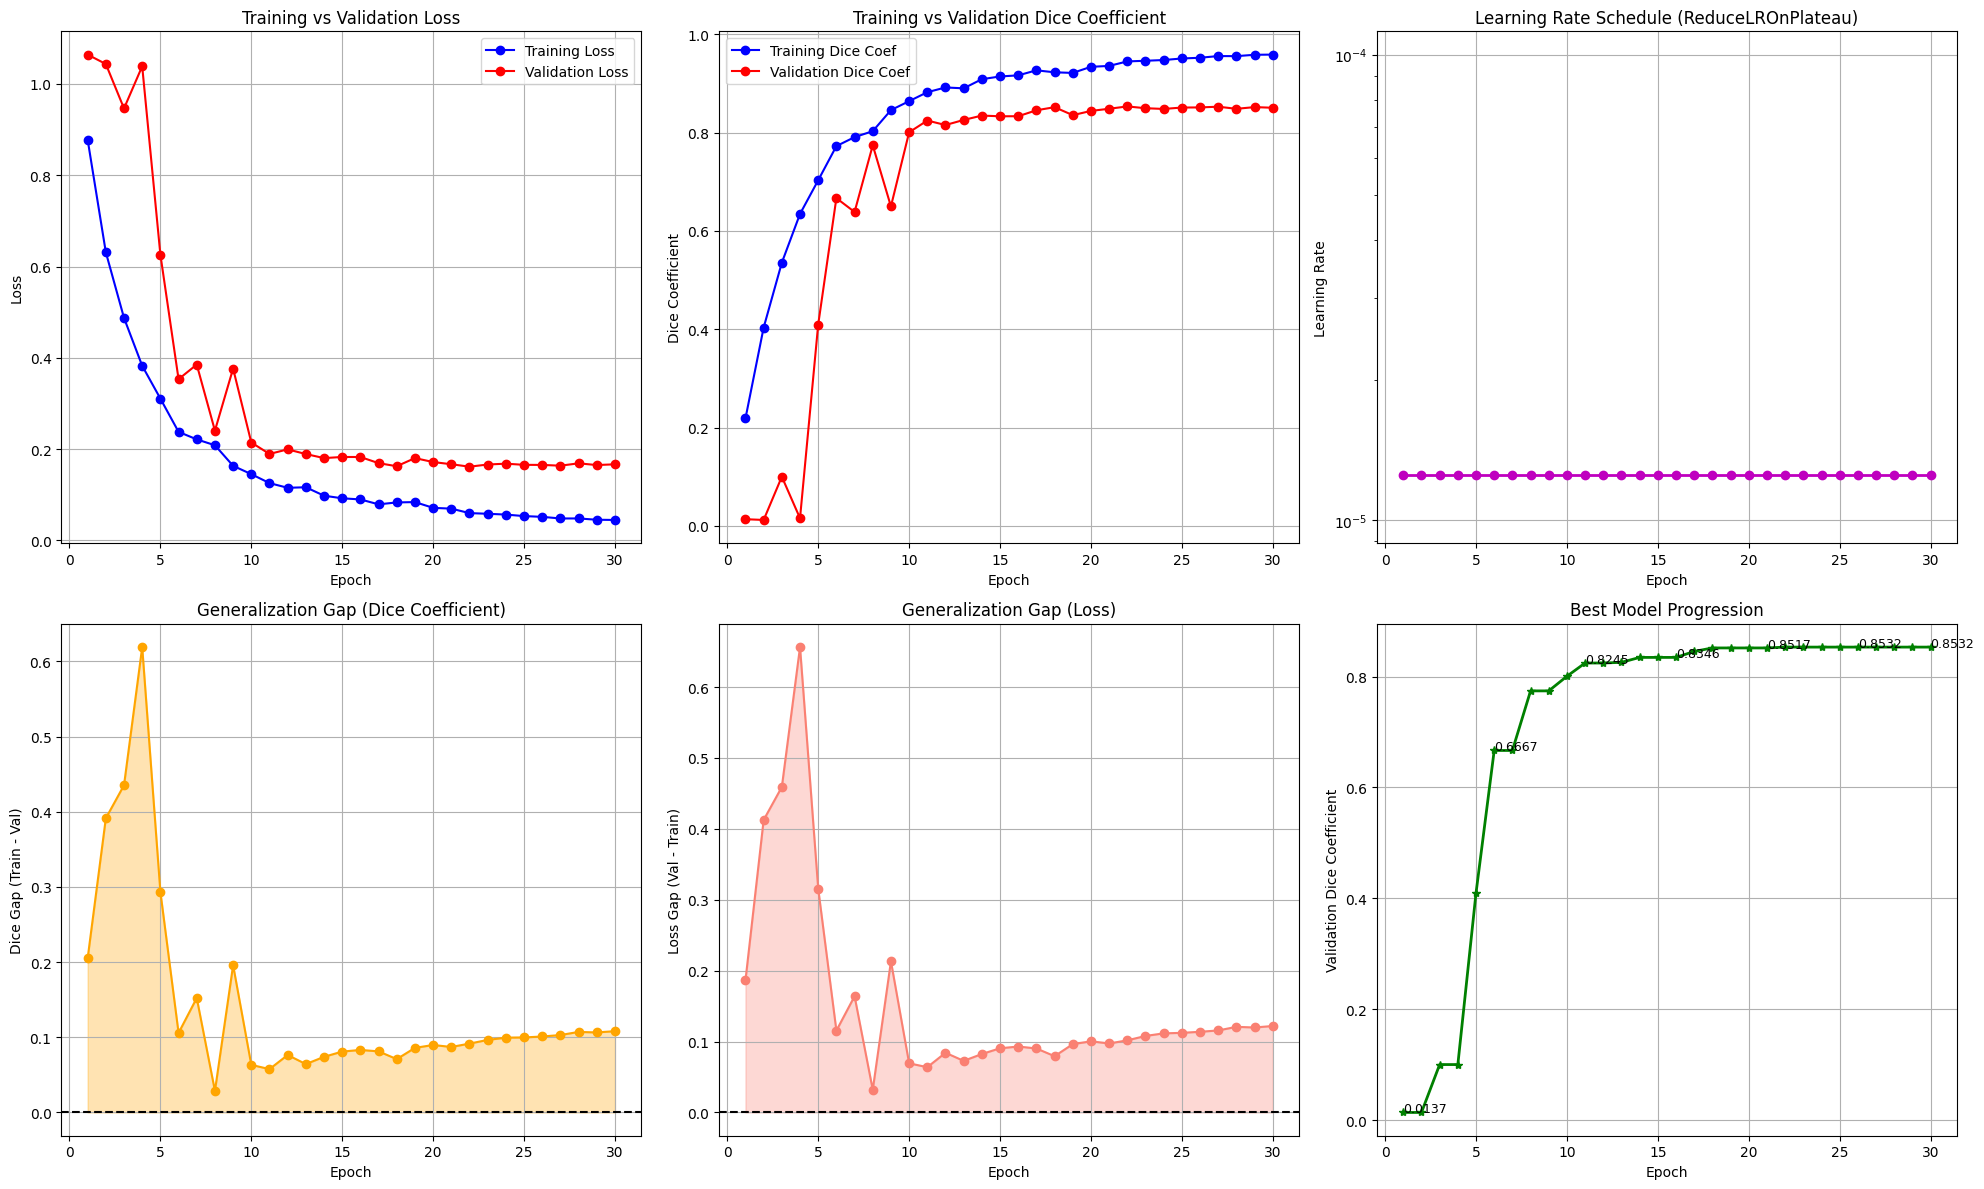

In [14]:
plt.figure(figsize=(20, 12))

# ---- 1. Training vs Validation Loss ----
plt.subplot(2, 3, 1)
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)

# ---- 2. Training vs Validation Dice ----
plt.subplot(2, 3, 2)
plt.plot(epochs, train_dice, 'bo-', label='Training Dice Coef')
plt.plot(epochs, val_dice, 'ro-', label='Validation Dice Coef')
plt.xlabel('Epoch')
plt.ylabel('Dice Coefficient')
plt.title('Training vs Validation Dice Coefficient')
plt.legend()
plt.grid(True)

# ---- 3. Learning Rate Schedule ----
plt.subplot(2, 3, 3)
plt.plot(epochs, lrs, 'mo-', linewidth=2)
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedule (ReduceLROnPlateau)')
plt.grid(True)

# ---- 4. Dice Generalization Gap ----
plt.subplot(2, 3, 4)
plt.plot(epochs, dice_gap, color='orange', marker='o')
plt.fill_between(epochs, dice_gap, alpha=0.3, color='orange')
plt.axhline(0, linestyle='--', color='black')
plt.xlabel('Epoch')
plt.ylabel('Dice Gap (Train - Val)')
plt.title('Generalization Gap (Dice Coefficient)')
plt.grid(True)

# ---- 5. Loss Generalization Gap ----
plt.subplot(2, 3, 5)
plt.plot(epochs, loss_gap, color='salmon', marker='o')
plt.fill_between(epochs, loss_gap, alpha=0.3, color='salmon')
plt.axhline(0, linestyle='--', color='black')
plt.xlabel('Epoch')
plt.ylabel('Loss Gap (Val - Train)')
plt.title('Generalization Gap (Loss)')
plt.grid(True)

# ---- 6. Best Model Progression ----
plt.subplot(2, 3, 6)
plt.plot(epochs, best_val_dice, 'g*-', linewidth=2)
for i, v in enumerate(best_val_dice):
    if i % 5 == 0 or i == len(best_val_dice) - 1:
        plt.text(i + 1, v, f"{v:.4f}", fontsize=9)
plt.xlabel('Epoch')
plt.ylabel('Validation Dice Coefficient')
plt.title('Best Model Progression')
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
###COMPARISIONPLOTS###

In [15]:
import matplotlib.pyplot as plt

def plot_training(history):
    epochs = range(1, len(history.history['loss']) + 1)

# training vs epoch plots
    plt.figure(figsize=(6,5))
    plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
    plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('accuracy_curve.png', dpi=300)
    plt.show()

    # loss plots
    plt.figure(figsize=(6,5))
    plt.plot(epochs, history.history['loss'], label='Training Loss')
    plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('loss_curve.png', dpi=300)
    plt.show()


    if 'mean_io_u' in history.history:
        plt.figure(figsize=(6,5))
        plt.plot(epochs, history.history['mean_io_u'], label='Training IoU')
        plt.plot(epochs, history.history['val_mean_io_u'], label='Validation IoU')
        plt.xlabel('Epochs')
        plt.ylabel('Mean IoU')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.savefig('iou_curve.png', dpi=300)
        plt.show()

In [ ]:
#### BLAND ANALYSIS PLOTS

In [16]:
def compute_volumes(y_true, y_pred):
    """
    y_true, y_pred: binary masks (H, W) or (H, W, D)
    returns volume (number of positive pixels/voxels)
    """
    return np.sum(y_true), np.sum(y_pred)

In [17]:
gt_volumes = []
pred_volumes = []

threshold = 0.5
max_samples = 50

for i in range(max_samples):
    x = X_val[i:i+1]
    y_true = y_val[i].squeeze()

    y_prob = model.predict(x, verbose=0)[0, ..., 0]
    y_pred = (y_prob > threshold).astype(np.float32)

    gt_v, pred_v = compute_volumes(y_true, y_pred)

    gt_volumes.append(gt_v)
    pred_volumes.append(pred_v)

gt_volumes = np.array(gt_volumes)
pred_volumes = np.array(pred_volumes)

In [18]:
means = (gt_volumes + pred_volumes) / 2
diffs = pred_volumes - gt_volumes

mean_diff = np.mean(diffs)
std_diff = np.std(diffs)

loa_upper = mean_diff + 1.96 * std_diff
loa_lower = mean_diff - 1.96 * std_diff

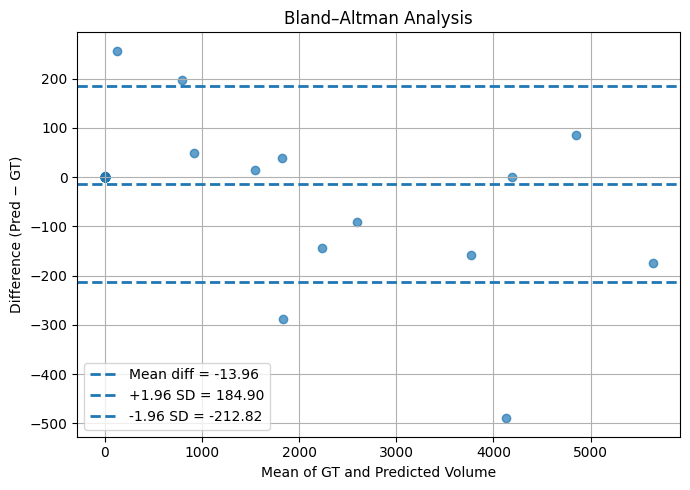

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,5))

plt.scatter(means, diffs, alpha=0.7)
plt.axhline(mean_diff, linestyle='--', linewidth=2, label=f'Mean diff = {mean_diff:.2f}')
plt.axhline(loa_upper, linestyle='--', linewidth=2, label=f'+1.96 SD = {loa_upper:.2f}')
plt.axhline(loa_lower, linestyle='--', linewidth=2, label=f'-1.96 SD = {loa_lower:.2f}')

plt.xlabel('Mean of GT and Predicted Volume')
plt.ylabel('Difference (Pred − GT)')
plt.title('Bland–Altman Analysis')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('bland_altman_volume.png', dpi=300)
plt.show()
### for ground truth image this plot is needed